In [ ]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score

import time
from sklearn.model_selection import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import *
import matplotlib.pyplot as plt
%matplotlib inline
import re
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

pd.set_option('display.max_rows',None)

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
import io

df_train= pd.read_csv(io.BytesIO(uploaded['VG_Train.csv']))
print(df_train.shape)

df_test= pd.read_csv(io.BytesIO(uploaded['VG_Test.csv']))
print(df_test.shape)

(3506, 9)
(1503, 8)


In [ ]:
df_train.columns

Index(['ID', 'CONSOLE', 'YEAR', 'CATEGORY', 'PUBLISHER', 'RATING',
       'CRITICS_POINTS', 'USER_POINTS', 'SalesInMillions'],
      dtype='object')

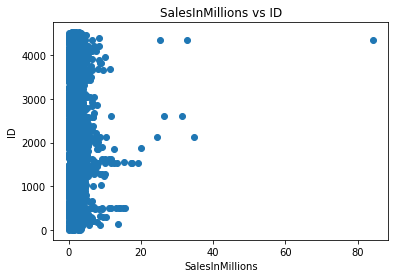

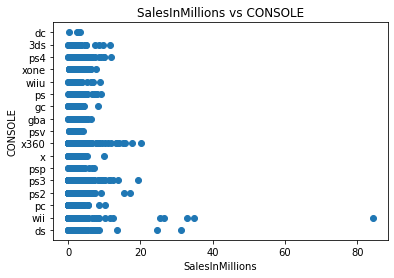

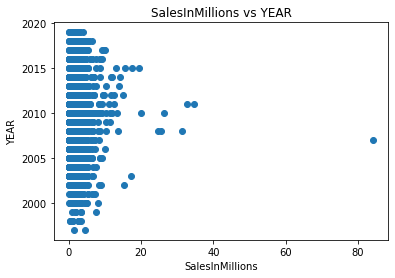

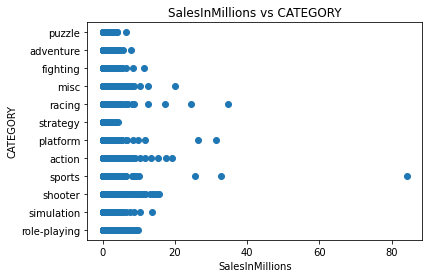

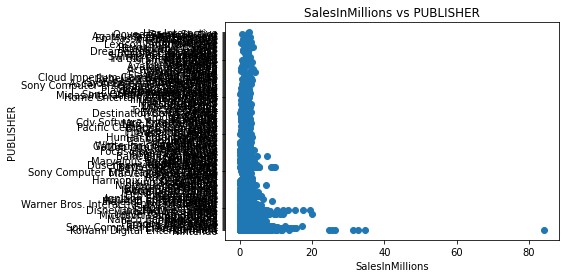

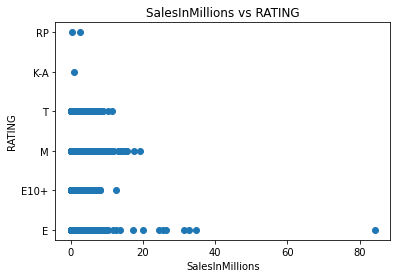

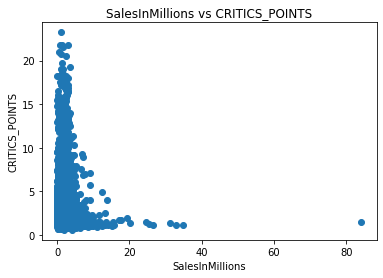

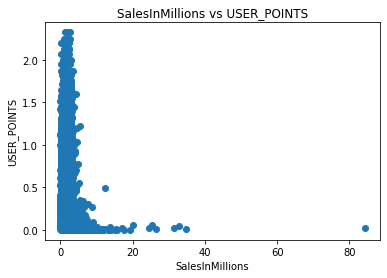

In [ ]:
x_col = "SalesInMillions"
y_columns = ['ID', 'CONSOLE', 'YEAR', 'CATEGORY', 'PUBLISHER', 'RATING',
       'CRITICS_POINTS', 'USER_POINTS']


for y_col in y_columns:

    figure = plt.figure
    ax = plt.gca()
    ax.scatter(df_train[x_col], df_train[y_col])
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_title("{} vs {}".format(x_col, y_col))

    plt.show()

KeyboardInterrupt: ignored

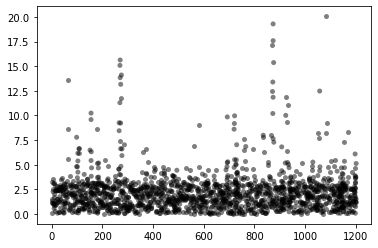

In [ ]:
import seaborn as sns

x_col = "SalesInMillions"
y_columns = ['ID', 'CONSOLE', 'YEAR', 'CATEGORY', 'PUBLISHER', 'RATING',
       'CRITICS_POINTS', 'USER_POINTS']

figure = plt.figure
ax = plt.subplot(111) 

for i in y_columns:

    sns.stripplot(y= x_col, x= i, data=df_train, jitter=True,marker='o', alpha=0.5,color='black')
    ax.set_xlabel(i)
    ax.set_ylabel(y_col)
    ax.set_title("{} vs {}".format(i, y_col))
    

    
    
    
    plt.show()

In [ ]:
#Q1=df_train['SalesInMillions'].quantile(0.25)
#Q3=df_train['SalesInMillions'].quantile(0.75)
#IQR=Q3-Q1
#print(Q1)
#print(Q3)
#print(IQR)
#Lower_Whisker = Q1-1.5*IQR
#Upper_Whisker = Q3+1.5*IQR
#print(Lower_Whisker, Upper_Whisker)

0.9656791142504674
2.7920286851175664
1.826349570867099
-1.773845242050181 5.531553041418215


In [ ]:
#df_train = df_train[df_train['SalesInMillions']< Upper_Whisker]
df_train.shape

(3506, 9)

In [ ]:
def mean_encode(train_data, test_data, columns, target_col, reg_method=None,
                alpha=5, add_random=False, rmean=0, rstd=0.1, folds=1):
    '''Returns a DataFrame with encoded columns'''
    encoded_cols = []
    target_mean_global = train_data[target_col].mean()
    for col in columns:
        # Getting means for test data
        nrows_cat = train_data.groupby(col)[target_col].count()
        target_means_cats = train_data.groupby(col)[target_col].mean()
        target_means_cats_adj = (target_means_cats*nrows_cat + 
                                 target_mean_global*alpha)/(nrows_cat+alpha)
        # Mapping means to test data
        encoded_col_test = test_data[col].map(target_means_cats_adj)
        # Getting a train encodings
        if reg_method == 'expanding_mean':
            train_data_shuffled = train_data.sample(frac=1, random_state=1)
            cumsum = train_data_shuffled.groupby(col)[target_col].cumsum() - train_data_shuffled[target_col]
            cumcnt = train_data_shuffled.groupby(col).cumcount()
            encoded_col_train = cumsum/(cumcnt)
            encoded_col_train.fillna(target_mean_global, inplace=True)
            if add_random:
                encoded_col_train = encoded_col_train + normal(loc=rmean, scale=rstd, 
                                                               size=(encoded_col_train.shape[0]))
        elif (reg_method == 'k_fold') and (folds > 1):
            kfold = KFold( n_splits = 10, shuffle = False)
            parts = []
            for tr_in, val_ind in kfold.split(train_data):
                # divide data
                df_for_estimation, df_estimated = train_data.iloc[tr_in], train_data.iloc[val_ind]
                # getting means on data for estimation (all folds except estimated)
                nrows_cat = df_for_estimation.groupby(col)[target_col].count()
                target_means_cats = df_for_estimation.groupby(col)[target_col].mean()
                target_means_cats_adj = (target_means_cats*nrows_cat + 
                                         target_mean_global*alpha)/(nrows_cat+alpha)
                # Mapping means to estimated fold
                encoded_col_train_part = df_estimated[col].map(target_means_cats_adj)
                if add_random:
                    encoded_col_train_part = encoded_col_train_part + normal(loc=rmean, scale=rstd, 
                                                                             size=(encoded_col_train_part.shape[0]))
                # Saving estimated encodings for a fold
                parts.append(encoded_col_train_part)
            encoded_col_train = pd.concat(parts, axis=0)
            encoded_col_train.fillna(target_mean_global, inplace=True)
        else:
            encoded_col_train = train_data[col].map(target_means_cats_adj)
            if add_random:
                encoded_col_train = encoded_col_train + normal(loc=rmean, scale=rstd, 
                                                               size=(encoded_col_train.shape[0]))

        # Saving the column with means
        encoded_col = pd.concat([encoded_col_train, encoded_col_test], axis=0)
        encoded_col[encoded_col.isnull()] = target_mean_global
        encoded_cols.append(pd.DataFrame({'mean_'+target_col+'_'+col:encoded_col}))
    all_encoded = pd.concat(encoded_cols, axis=1)
    return all_encoded

In [ ]:
cols = y_columns
target = x_col
finaldf = mean_encode(df_train,df_test,cols,target,reg_method='k_fold',folds=5)
finaldf.head()

,mean_SalesInMillions_ID,mean_SalesInMillions_CONSOLE,mean_SalesInMillions_YEAR,mean_SalesInMillions_CATEGORY,mean_SalesInMillions_PUBLISHER,mean_SalesInMillions_RATING,mean_SalesInMillions_CRITICS_POINTS,mean_SalesInMillions_USER_POINTS
0,2.171021,2.185797,2.270856,2.111201,4.286389,2.437184,2.401005,2.111513
1,2.171021,2.941243,2.165342,2.103497,1.781607,1.878356,2.049944,1.910734
2,2.615032,1.769688,1.671641,2.491630,2.388049,2.484016,2.262033,2.171021
3,2.171021,2.185907,2.285194,2.352478,2.331842,2.437184,2.002680,2.052188
4,2.171021,2.280501,2.140816,2.080454,2.388049,2.484016,2.030408,2.171021


In [ ]:
finaldf.shape

(5009, 8)

In [ ]:
train_encoded = finaldf.iloc[0:3506,:]
print(train_encoded.shape)

test_encoded = finaldf.iloc[3506:,:]
print(test_encoded.shape)

(3506, 8)
(1503, 8)


In [ ]:
X = train_encoded.copy()
y = df_train['SalesInMillions']
Xt = test_encoded.copy()

In [ ]:
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred) ** 0.5

In [ ]:
features = [c for c in X.columns]
print(features)

['mean_SalesInMillions_ID', 'mean_SalesInMillions_CONSOLE', 'mean_SalesInMillions_YEAR', 'mean_SalesInMillions_CATEGORY', 'mean_SalesInMillions_PUBLISHER', 'mean_SalesInMillions_RATING', 'mean_SalesInMillions_CRITICS_POINTS', 'mean_SalesInMillions_USER_POINTS']


In [ ]:
training_start_time = time.time()
rmsle = list()
max_iter = 10
folds = StratifiedKFold(n_splits = max_iter)
oofs = np.zeros(len(X))
test_preds = np.zeros(len(Xt))


for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, pd.qcut(y, 10, labels=False, duplicates='drop'))):
    
    print(f'\n---- Fold {fold_} -----\n')
    
    X_trn, y_trn = X.iloc[trn_idx][features], y.iloc[trn_idx]
    X_val, y_val = X.iloc[val_idx][features], y.iloc[val_idx]
    X_test = Xt[features]
    
    xgb = XGBRegressor(n_estimators=1000, max_depth=12, learning_rate=0.05, colsample_bytree=0.45)
    _ = xgb.fit(X_trn, np.log(y_trn), eval_set = [(X_val, np.log(y_val))], verbose=100, early_stopping_rounds=100, eval_metric='rmse')
    
    oofs[val_idx] = np.exp(xgb.predict(X_val))
    current_test_pred = np.exp(xgb.predict(X_test))
    test_preds += np.exp(xgb.predict(X_test))/max_iter
    
    print(f'\n Fold {rmse(np.log(y_val), np.log(oofs[val_idx]))}')
    rmsle = np.append(rmsle, rmse(np.log(y_val), np.log(oofs[val_idx])))
    

print(f'\nOOF val score: {rmse(np.log(y), np.log(oofs))}')
print(f'Mean rmsle: {np.mean(rmsle):.4f} and std Dev. is {np.std(rmsle):.2f} \n')



---- Fold 0 -----

[04:17:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.957851
Will train until validation_0-rmse hasn't improved in 100 rounds.
[100]	validation_0-rmse:0.983783
Stopping. Best iteration:
[11]	validation_0-rmse:0.951931


 Fold 0.9519313197436567

---- Fold 1 -----

[04:17:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.912963
Will train until validation_0-rmse hasn't improved in 100 rounds.
[100]	validation_0-rmse:0.914631
Stopping. Best iteration:
[29]	validation_0-rmse:0.889536


 Fold 0.8895360166937134

---- Fold 2 -----

[04:17:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.918536
Will train until validation_0-rmse hasn't improved in 100 rounds.
[100]	validation_0-rmse:1.0007
S

In [ ]:
training_start_time = time.time()

rmsle = list()
max_iter = 10
folds = StratifiedKFold(n_splits = max_iter)
oofs = np.zeros(len(X))
test_preds = np.zeros(len(Xt))


for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, pd.qcut(y, 10, labels=False, duplicates='drop'))):
    
    print(f'\n---- Fold {fold_} -----\n')
    
    X_trn, y_trn = X.iloc[trn_idx][features], y.iloc[trn_idx]
    X_val, y_val = X.iloc[val_idx][features], y.iloc[val_idx]
    X_test = Xt[features]
     
    lgbm = LGBMRegressor(n_estimators=1000, num_leaves=127, max_depth=-1,min_child_samples=4, learning_rate=0.02, colsample_bytree=0.4, reg_alpha=0.5, reg_lambda=2)
    _ = lgbm.fit(X_trn, np.log(y_trn), eval_set = [(X_val, np.log(y_val))], verbose=100, early_stopping_rounds=100, eval_metric='rmse')

    oofs[val_idx] = np.exp(lgbm.predict(X_val))
    current_test_pred = np.exp(lgbm.predict(X_test))
    test_preds += np.exp(lgbm.predict(X_test))/max_iter
    
    print(f'\n Fold {rmse(np.log(y_val), np.log(oofs[val_idx]))}')
    rmsle = np.append(rmsle, rmse(np.log(y_val), np.log(oofs[val_idx])))
    
    
print(f'\nOOF val score: {rmse(np.log(y), np.log(oofs))}')
print(f'Mean rmsle: {np.mean(rmsle):.4f} and std Dev. is {np.std(rmsle):.2f} \n')


---- Fold 0 -----

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 0.904593	valid_0's rmse: 0.951101
Early stopping, best iteration is:
[26]	valid_0's l2: 0.887893	valid_0's rmse: 0.942281

 Fold 0.9422807654579853

---- Fold 1 -----

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 0.801932	valid_0's rmse: 0.895507
Early stopping, best iteration is:
[61]	valid_0's l2: 0.794816	valid_0's rmse: 0.891524

 Fold 0.8915243329915197

---- Fold 2 -----

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 0.885273	valid_0's rmse: 0.940889
Early stopping, best iteration is:
[3]	valid_0's l2: 0.821354	valid_0's rmse: 0.906286

 Fold 0.9062856617257206

---- Fold 3 -----

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 1.17313	valid_0's rmse: 1.08311
Early stopping, best iteration is:
[4]	valid_0's l2: 1.14487	valid_0's rmse: 1.06999

 Fold 1.069986027997058

--

In [ ]:
rmsle = list()
max_iter = 10
folds = StratifiedKFold(n_splits = max_iter)
oofs = np.zeros(len(X))
test_preds = np.zeros(len(Xt))


for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, pd.qcut(y, 10, labels=False, duplicates='drop'))):
    
    print(f'\n---- Fold {fold_} -----\n')
    
    X_trn, y_trn = X.iloc[trn_idx][features], y.iloc[trn_idx]
    X_val, y_val = X.iloc[val_idx][features], y.iloc[val_idx]
    X_test = Xt[features]
    
    cat = CatBoostRegressor(n_estimators=2000, learning_rate=0.05, max_depth=9,loss_function='RMSE')
    _ = cat.fit(X_trn, np.log(y_trn), eval_set = [(X_val, np.log(y_val))], verbose=100, early_stopping_rounds=100)
    
    oofs[val_idx] = np.exp(cat.predict(X_val))
    current_test_pred = np.exp(cat.predict(X_test))
    test_preds += np.exp(cat.predict(X_test))/max_iter
    
    print(f'\n Fold {rmse(np.log(y_val), np.log(oofs[val_idx]))}')
    rmsle = np.append(rmsle, rmse(np.log(y_val), np.log(oofs[val_idx])))
    

print(f'\nOOF val score: {rmse(np.log(y), np.log(oofs))}')
print(f'Mean rmsle: {np.mean(rmsle):.4f} and std Dev. is {np.std(rmsle):.2f} \n')


---- Fold 0 -----

0:	learn: 0.9902100	test: 0.9454323	best: 0.9454323 (0)	total: 60.6ms	remaining: 2m 1s
100:	learn: 0.8469055	test: 0.9431121	best: 0.9424563 (31)	total: 1.08s	remaining: 20.3s
200:	learn: 0.7585940	test: 0.9475569	best: 0.9407182 (112)	total: 2.07s	remaining: 18.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9407181758
bestIteration = 112

Shrink model to first 113 iterations.

 Fold 0.9407181700341213

---- Fold 1 -----

0:	learn: 0.9947564	test: 0.9029804	best: 0.9029804 (0)	total: 11.3ms	remaining: 22.7s
100:	learn: 0.8514485	test: 0.8913262	best: 0.8893376 (52)	total: 1s	remaining: 18.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8893376095
bestIteration = 52

Shrink model to first 53 iterations.

 Fold 0.8893376102451667

---- Fold 2 -----

0:	learn: 0.9946406	test: 0.9063868	best: 0.9063868 (0)	total: 11.3ms	remaining: 22.6s
100:	learn: 0.8529152	test: 0.8993289	best: 0.8965301 (61)	total: 1.01s	remaining: 19s

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=0)

In [ ]:
def learning_rate_010_decay_power_099(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_010_decay_power_0995(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.995, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_005_decay_power_099(current_iter):
    base_learning_rate = 0.05
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

In [ ]:
## early stopping criterion

import lightgbm as lgb
fit_params={"early_stopping_rounds":100, 
            "eval_metric" : 'rmse', 
            "eval_set" : [(X_val,y_val)],
            'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
            'verbose': 100}


In [ ]:
## hyperparmeter tuning
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [ ]:
lgb_reg = lgb.LGBMRegressor(max_depth=-1, random_state=0, metric='rmse', n_jobs=4, n_estimators=5000)
gs = RandomizedSearchCV(
    estimator=lgb_reg, param_distributions=param_test,
    cv=3,
    refit=True,
    random_state=314,
    verbose=True)

gs.fit(X_train, y_train, **fit_params)
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 2.08997


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[200]	valid_0's rmse: 2.08428
[300]	valid_0's rmse: 2.08275
[400]	valid_0's rmse: 2.08239
[500]	valid_0's rmse: 2.08223
[600]	valid_0's rmse: 2.08212
[700]	valid_0's rmse: 2.08203
[800]	valid_0's rmse: 2.0819
[900]	valid_0's rmse: 2.08181
[1000]	valid_0's rmse: 2.0817
[1100]	valid_0's rmse: 2.08159
[1200]	valid_0's rmse: 2.08151
[1300]	valid_0's rmse: 2.0814
[1400]	valid_0's rmse: 2.08131
[1500]	valid_0's rmse: 2.08124
[1600]	valid_0's rmse: 2.08115
[1700]	valid_0's rmse: 2.08109
[1800]	valid_0's rmse: 2.08101
[1900]	valid_0's rmse: 2.0809
[2000]	valid_0's rmse: 2.08081
[2100]	valid_0's rmse: 2.08069
[2200]	valid_0's rmse: 2.08058
[2300]	valid_0's rmse: 2.08046
[2400]	valid_0's rmse: 2.08036
[2500]	valid_0's rmse: 2.08027
[2600]	valid_0's rmse: 2.08017
[2700]	valid_0's rmse: 2.0801
[2800]	valid_0's rmse: 2.07996
[2900]	valid_0's rmse: 2.07975
[3000]	valid_0's rmse: 2.07957
[3100]	valid_0's rmse: 2.07944
[3200]	valid_0's rmse: 2.07933
[3300]	valid_0's rmse: 2.07922
[3400]	valid_0's rmse

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   35.3s finished


[100]	valid_0's rmse: 2.04798
[200]	valid_0's rmse: 2.04541
[300]	valid_0's rmse: 2.04383
[400]	valid_0's rmse: 2.04353
[500]	valid_0's rmse: 2.04313
[600]	valid_0's rmse: 2.04297
[700]	valid_0's rmse: 2.04274
[800]	valid_0's rmse: 2.04256
[900]	valid_0's rmse: 2.04246
[1000]	valid_0's rmse: 2.04235
[1100]	valid_0's rmse: 2.0422
[1200]	valid_0's rmse: 2.04206
[1300]	valid_0's rmse: 2.04201
[1400]	valid_0's rmse: 2.042
[1500]	valid_0's rmse: 2.0418
[1600]	valid_0's rmse: 2.04181
[1700]	valid_0's rmse: 2.04173
[1800]	valid_0's rmse: 2.04169
[1900]	valid_0's rmse: 2.04165
Early stopping, best iteration is:
[1849]	valid_0's rmse: 2.04156
Best score reached: 0.09759104470535307 with params: {'colsample_bytree': 0.6879091728281055, 'min_child_samples': 163, 'min_child_weight': 10.0, 'num_leaves': 10, 'reg_alpha': 1, 'reg_lambda': 0.1, 'subsample': 0.6775057521029393} 


In [ ]:
## early stopping criterion for catboost

import catboost

fit_params={"early_stopping_rounds":100, 
            "eval_set" : [(X_val,y_val)],
            'verbose': 100}

## hyperparameter tuning of catboost

params = {'depth':[3,1,2,6,4,5,7,8,9,10],
          'iterations':[250,100,500,1000],
          'learning_rate':[0.05,0.03,0.001,0.01,0.1,0.2], 
          'l2_leaf_reg':[3,1,5,10,100]}

In [ ]:
cat_reg = catboost.CatBoostRegressor(loss_function='RMSE')
cs = RandomizedSearchCV(
    estimator=cat_reg, param_distributions=params,
    cv=5,
    refit=True,
    random_state=314,
    verbose=True)

cs.fit(X_train, y_train, **fit_params)
print('Best score reached: {} with params: {} '.format(cs.best_score_, cs.best_params_))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
0:	learn: 2.5822077	test: 2.1862688	best: 2.1862688 (0)	total: 1.79ms	remaining: 177ms
99:	learn: 1.6340743	test: 2.0456247	best: 2.0097477 (52)	total: 131ms	remaining: 0us

bestTest = 2.009747668
bestIteration = 52

Shrink model to first 53 iterations.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0:	learn: 2.0321403	test: 2.1727430	best: 2.1727430 (0)	total: 1.23ms	remaining: 122ms
99:	learn: 1.5149060	test: 1.9884177	best: 1.9614064 (58)	total: 122ms	remaining: 0us

bestTest = 1.961406413
bestIteration = 58

Shrink model to first 59 iterations.
0:	learn: 2.6344929	test: 2.1660700	best: 2.1660700 (0)	total: 1.25ms	remaining: 124ms
99:	learn: 1.6320648	test: 2.0248843	best: 2.0140300 (36)	total: 139ms	remaining: 0us

bestTest = 2.014029992
bestIteration = 36

Shrink model to first 37 iterations.
0:	learn: 2.6862950	test: 2.1862054	best: 2.1862054 (0)	total: 1.43ms	remaining: 141ms
99:	learn: 1.6703925	test: 1.9562633	best: 1.9440424 (58)	total: 127ms	remaining: 0us

bestTest = 1.944042434
bestIteration = 58

Shrink model to first 59 iterations.
0:	learn: 2.6738048	test: 2.1658658	best: 2.1658658 (0)	total: 1.32ms	remaining: 131ms
99:	learn: 1.7149654	test: 2.0283447	best: 1.9982472 (41)	total: 125ms	remaining: 0us

bestTest = 1.998247236
bestIteration = 41

Shrink model to first

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   38.5s finished


100:	learn: 1.7517619	test: 1.9775024	best: 1.9771341 (98)	total: 590ms	remaining: 5.25s
200:	learn: 1.4759711	test: 1.9613660	best: 1.9574064 (169)	total: 1.17s	remaining: 4.66s
300:	learn: 1.3386204	test: 1.9453792	best: 1.9453792 (300)	total: 1.77s	remaining: 4.1s
400:	learn: 1.2389040	test: 1.9503356	best: 1.9453294 (305)	total: 2.33s	remaining: 3.49s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.945329356
bestIteration = 305

Shrink model to first 306 iterations.
Best score reached: 0.23757380000536604 with params: {'learning_rate': 0.03, 'l2_leaf_reg': 3, 'iterations': 1000, 'depth': 8} 
